In [1]:
# prequisites
#uproot High energy physics python file format => https://masonproffitt.github.io/uproot-tutorial/aio.html
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os,sys
#plotting style for High Energy physics 
import lmfit as lm
import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
#Now lets look at the data. Our data sample is the JetHT dataset. 
#What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data   = uproot.open("data/JetHT_s.root")["Tree"]
#In addition to above we have Monte Carlo Simulation of many processes
#Some of these process are well modelled in simulation and some of them are not
#Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq    = uproot.open("data/WQQ_s.root")["Tree"]
#Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq    = uproot.open("data/ZQQ_s.root")["Tree"]
#Unfortunately the samples I made above a long time ago are very small. 
#To train NNs and make nice plots we will use larger samples produced at a different collision energy
#qq=>W=>qq at 13TeV collision energy
wqq13  = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
#qq=>Z=>qq at 13TeV collision energy
zqq13  = uproot.open("data/skimh/ZQQ_sh.root")["Tree"]
#Now we have our worst modeled background this is also our main background. 
#This is is our di-jet quark and gluon background. 
#We just call these backgrounds QCD because they are produced with Quantum chromo dynamics. 
qcd    = uproot.open("data/QCD_s.root")["Tree"]
#Now we have the Higgs boson sample (we might need this in the future)
ggh    = uproot.open("data/ggH.root")["Tree"]
#And top-quark pair production background. 
tt     = uproot.open("data/TT.root")["Tree"]
#Finally we have the rarer double W, W+Z and Z+Z diboson samples where we have two bosons instead of one
ww     = uproot.open("data/WW.root")["Tree"]
wz     = uproot.open("data/WZ.root")["Tree"]
zz     = uproot.open("data/ZZ.root")["Tree"]

In [3]:
def selection(iData):
        #lets apply a trigger selection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
        #Now lets require the jet pt to be above a threshold
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
        #Lets apply both jetpt and trigger at the same time
        #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
        allcuts = np.logical_and.reduce([trigger,jetpt])
        return allcuts
def get_weights(iData,weights,sel):
    weight = weights[0]
    for i in range(1,len(weights)):
        weight *= iData.arrays(weights[i],library="np")[weights[i]][sel]
    return weight

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


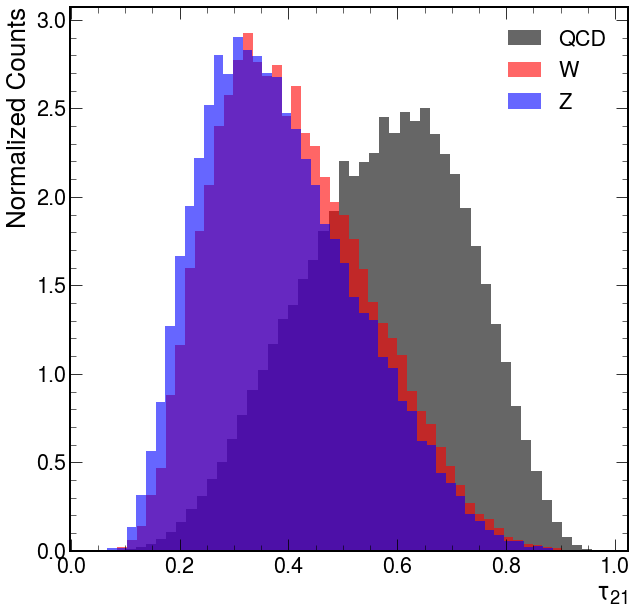

In [4]:
#Lets Look at the N subjettiness mass of QCD background compared to W 
#first of all for MC, we need to apply some standard weights
weights=[1000*18300,"puweight","scale1fb"]

qcdsel      = selection(qcd)
wsel        = selection(wqq13)
zsel        = selection(zqq13)
#selection  ggH 
# htrig       = (ggh.arrays('trigger',library="np")["trigger"].flatten() % 2 > 0)
# hpt         = (ggh.arrays('vjet0_pt',library="np")["vjet0_pt"].flatten() > 400)
# hsel        = np.logical_and.reduce([htrig,hpt])
# ht21 = (ggh.arrays('vjet0_t2', library="np")["vjet0_t2"][hsel]/
#           ggh.arrays('vjet0_t1', library="np")["vjet0_t1"][hsel])

# Compute the t2 to t1 ratio
qcdt21 = (qcd.arrays('vjet0_t2', library="np")["vjet0_t2"][qcdsel]/
          qcd.arrays('vjet0_t1', library="np")["vjet0_t1"][qcdsel])
wt21 = (wqq13.arrays('vjet0_t2', library="np")["vjet0_t2"][wsel]/
          wqq13.arrays('vjet0_t1', library="np")["vjet0_t1"][wsel])
zt21 = (zqq13.arrays('vjet0_t2', library="np")["vjet0_t2"][zsel]/
          zqq13.arrays('vjet0_t1', library="np")["vjet0_t1"][zsel])


plt.hist(qcdt21, weights=get_weights(qcd,weights,qcdsel),
         bins=50, color='black',label="QCD", alpha=.6, density=True)
plt.hist(wt21, weights=get_weights(wqq13,weights,wsel),
         bins=50, color='red',label="W", alpha=.6, density=True)
plt.hist(zt21, weights=get_weights(zqq13,weights,zsel),
         bins=50, color='blue',label="Z", alpha=.6, density=True)
# plt.hist(ht21, weights=get_weights(ggh,weights,hsel),
#          bins=50, color='black',label="H", alpha=.6, density=True)
plt.legend()
plt.xlabel(r"$\tau_{21}$")
plt.ylabel("Normalized Counts")
plt.show()

In [5]:
#This computs the integral of weighted events assuming a selection given by the function selection(see below)
def integral(iData,iWeights):
    #perform a selection on the data (
    mask_sel=selection(iData)
    #now iterate over the weights not the weights are in the format of [number,variable name 1, variable name 2,...]
    weight  =iWeights[0]
    for i0 in range(1,len(iWeights)):
        weightarr = iData.arrays(iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        #multiply the weights
        weight    = weight*weightarr
    #now take the integral and return it
    return np.sum(weight)

#This computes the integral of two selections for two datasets labelled 8TeV and 13TeV, but really can be 1 and 2
#Then it returns the ratio of the integrals
def scale(iData8TeV,iData13TeV,iWeights):
    int_8TeV  = integral(iData8TeV,iWeights)
    int_13TeV = integral(iData13TeV,iWeights)
    print("Scale:",int_8TeV/int_13TeV,int_8TeV,int_13TeV)
    return int_8TeV/int_13TeV

In [6]:
def selectiont21(iData):
        #lets apply a trigger selection
        trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() >= 0)
        #Now lets require the jet pt to be above a threshold
        #jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
        jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() >= 400)
        #jetpt   = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
        rho = np.log(iData.arrays('vjet0_msd0',library="np")["vjet0_msd0"]**2/iData.arrays('vjet0_pt',library="np")["vjet0_pt"])
        t21 = (iData.arrays('vjet0_t2', library="np")["vjet0_t2"]/
               iData.arrays('vjet0_t1', library="np")["vjet0_t1"])
        t21ddt=t21+.05*rho #0.063
        t21cut   = t21ddt < .62 #0.65
        ddb=iData.arrays("vjet0_sj1_csv", library="np")["vjet0_sj1_csv"]+iData.arrays("vjet0_sj2_csv", library="np")["vjet0_sj2_csv"]
        ddbcut = ddb >= 1.85#1.85
        allcuts = np.logical_and.reduce([trigger,jetpt, t21cut, ddbcut])
        return allcuts

Scale: 1.6836067433254933 14748.133987809199 8759.844925946538
Scale: 0.6932541250123121 5663.988480165775 8170.147534376638


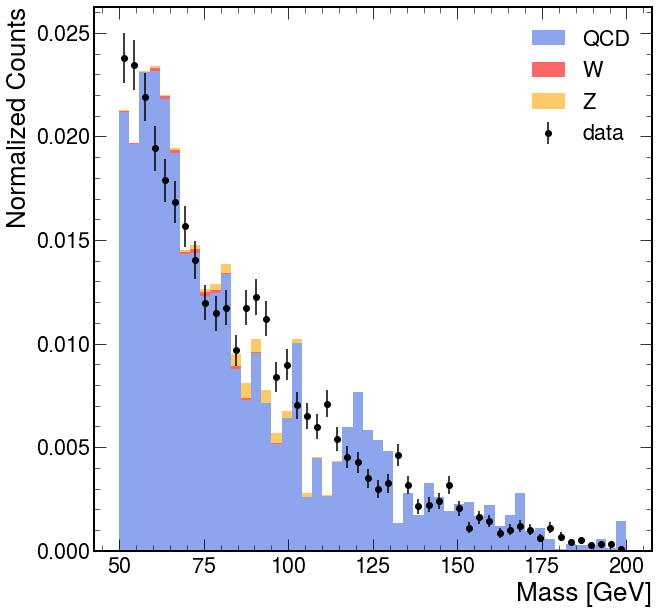

In [7]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
mrange = (50,200)
bins=50
density = True

qcdsel      = selectiont21(qcd)
wsel        = selectiont21(wqq13)
zsel        = selectiont21(zqq13)
datasel     = selectiont21(data)

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)
#selection  ggH 
# htrig       = (ggh.arrays('trigger',library="np")["trigger"].flatten() % 2 > 0)
# hpt         = (ggh.arrays('vjet0_pt',library="np")["vjet0_pt"].flatten() > 400)
# hsel        = np.logical_and.reduce([htrig,hpt])
# ht21 = (ggh.arrays('vjet0_t2', library="np")["vjet0_t2"][hsel]/
#           ggh.arrays('vjet0_t1', library="np")["vjet0_t1"][hsel])

# Compute the t2 to t1 ratio
datat21 = data.arrays('vjet0_msd0', library="np")["vjet0_msd0"][datasel]
qcdt21 = qcd.arrays('vjet0_msd0', library="np")["vjet0_msd0"][qcdsel]
wt21 = wqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][wsel]
zt21 = zqq13.arrays('vjet0_msd0', library="np")["vjet0_msd0"][zsel]

hist_weights = [get_weights(qcd,weights,qcdsel),
                get_weights(wqq13,weights,wsel)*wscale,
                get_weights(zqq13,weights,zsel)*zscale]

plt.hist([qcdt21,wt21, zt21], color=["royalblue",'r', 'orange'], label=["QCD", "W", "Z"], weights=hist_weights,
         range=mrange, bins=50, alpha=.6, density=density,stacked=True)
counts, bins = np.histogram(datat21,bins=bins,range=mrange,density=density)
yerr = np.sqrt(counts) / np.sqrt(len(datat21)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data")
# plt.hist(datat21, range=mrange,
#          bins=50, color='k',label="data", alpha=.6, density=density)
# plt.hist(wt21, weights=get_weights(wqq13,weights,wsel)*wscale, range=mrange,
#          bins=50, color='red',label="W", alpha=.6, density=density)
# plt.hist(zt21, weights=get_weights(zqq13,weights,zsel)*zscale, range=mrange,
#          bins=50, color='blue',label="Z", alpha=.6, density=density)
# plt.hist(ht21, weights=get_weights(ggh,weights,hsel),
#          bins=50, color='black',label="H", alpha=.6, density=True)
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()

In [8]:
qcdweights = get_weights(qcd,weights,qcdsel)
counts_data, bins = np.histogram(datat21,bins=40,range=mrange, density=True)
counts_qcd, bins = np.histogram(qcdt21,bins=bins, density=True, weights=qcdweights)
counts = counts_data# - counts_qcd
yvar = counts_data/len(datat21)/(bins[1]-bins[0]) #+ counts_qcd/sum(qcdweights)/(bins[1]-bins[0])
w = 1/np.sqrt(yvar)
binCenters = (bins[1:]+bins[:-1])*.5
x,y = binCenters.astype("float32"), counts.astype("float32")

[[Model]]
    Model(polgaus2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 40
    # variables        = 8
    chi-square         = 43.345673
    reduced chi-square = 1.35455227
    Akaike info crit   = 19.2130968
    Bayesian info crit = 32.7241324
[[Variables]]
    p0:     8.2585e-11 +/- 3.1993e-11 (38.74%) (init = -2.9898e-09)
    p1:    -5.3675e-08 +/- 1.7415e-08 (32.44%) (init = 2.0335e-06)
    p2:     1.3477e-05 +/- 3.4227e-06 (25.40%) (init = -0.00046726)
    p3:    -0.00159524 +/- 2.8479e-04 (17.85%) (init = 0.03619398)
    p4:     0.07736421 +/- 0.00834376 (10.79%) (init = -0.01)
    a:      0.00295426 +/- 8.4589e-04 (28.63%) (init = 1)
    mu:     91.4140924 +/- 1.09309031 (1.20%) (init = 92)
    sigma:  3.53102641 +/- 1.17043447 (33.15%) (init = 2.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1)    = -0.998
    C(p1, p2)    = -0.997
    C(p2, p3)    = -0.996
    C(p3, p4)    = -0.994
    C(p0, p

43.345673

<Figure size 720x720 with 0 Axes>

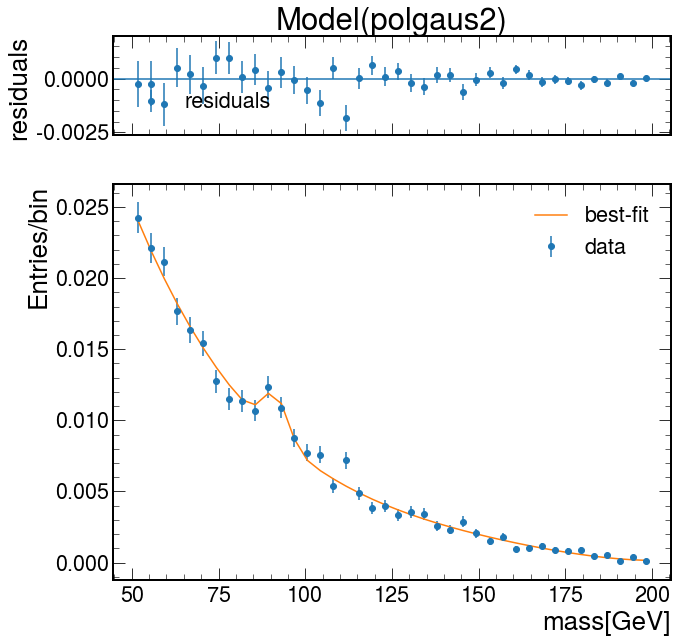

In [9]:
def polgaus2(x, p0, p1, p2, p3,p4, a, mu, sigma):
    pols=[p0, p1, p2, p3, p4]
    #legendre_poly = np.polynomial.Legendre(pols)
    poly  = np.polyval(pols,x)
#     exp   = np.exp(-lambd*x)
    gauss = np.exp(-((x-mu)**2.)/(2.*sigma**2))
    y =  poly + a*gauss #+ b*exp
    return y

model = lm.Model(polgaus2,)
p = model.make_params(p0=-2.9898e-09,p1=2.0335e-06,p2=-4.6726e-04,
                      p3=0.03619398,p4=-.01,p5=.01,
                      a=1,b=-0.00188134,
                      lambd=1,mu=92,sigma=2.5)
result = model.fit(data=y, params=p, x=x, weights=w)
plt.figure()
result.plot()
plt.xlabel("mass[GeV]",position=(0.92,0.1))
plt.ylabel("Entries/bin",position=(0.1,0.84))
print(result.fit_report())
result.chisqr

In [10]:
from scipy.stats import chi2
1-chi2.cdf(43,df=32)

0.09269484822418661